In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
#from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/home/harsh/ml/dl/Labs/opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
/home/harsh/ml/dl/Labs/opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


In [1]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        ### END CODE HERE ###
        
    return parameters

In [16]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches= []
    
    permutation =  list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape(1,m)
    
    num_complete_minibatches =  math.floor(m/mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size !=0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [35]:
# GRADED FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l+1)])
        ### END CODE HERE ###
        
    return v

In [36]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # n
    for l in range(L):
        v["W"+str(l+1)] = beta * v["dW" +str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v["b"+str(l+1)] = beta * v["db" +str(l+1)] + (1-beta) * grads['db' + str(l+1)]
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] -  learning_rate * v["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * v["db"+str(l+1)]
    
    return parameters, v
        

In [28]:


# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
    ### END CODE HERE ###
    
    return v, s

In [29]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
        
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)
        ### END CODE HERE ###

    return parameters, v, s
        

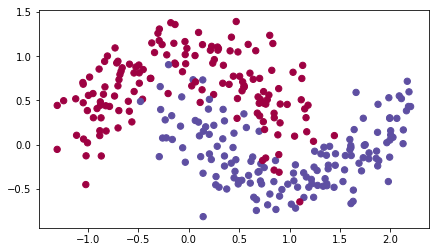

In [30]:
train_X, train_Y = load_dataset()

In [21]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


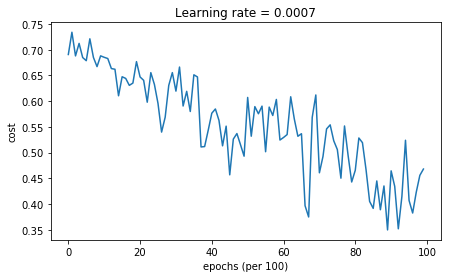

Accuracy: 0.796666666667


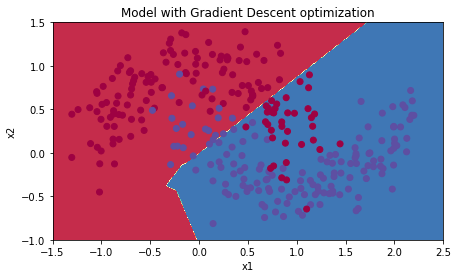

In [22]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.690742
Cost after epoch 1000: 0.727996
Cost after epoch 2000: 0.685290
Cost after epoch 3000: 0.689502
Cost after epoch 4000: 0.703992
Cost after epoch 5000: 0.704044
Cost after epoch 6000: 0.698919
Cost after epoch 7000: 0.716973
Cost after epoch 8000: 0.692783
Cost after epoch 9000: 0.693367


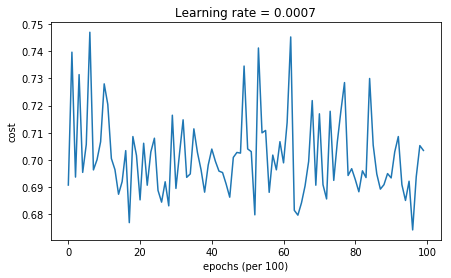

Accuracy: 0.5


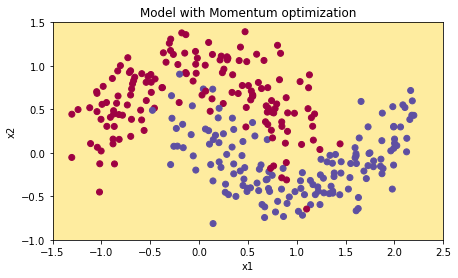

In [37]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer="momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.687550
Cost after epoch 1000: 0.173593
Cost after epoch 2000: 0.150145
Cost after epoch 3000: 0.072939
Cost after epoch 4000: 0.125896
Cost after epoch 5000: 0.104185
Cost after epoch 6000: 0.116069
Cost after epoch 7000: 0.031774
Cost after epoch 8000: 0.112908
Cost after epoch 9000: 0.197732


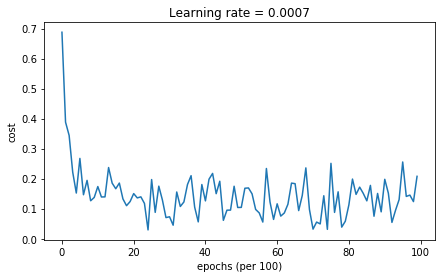

Accuracy: 0.94


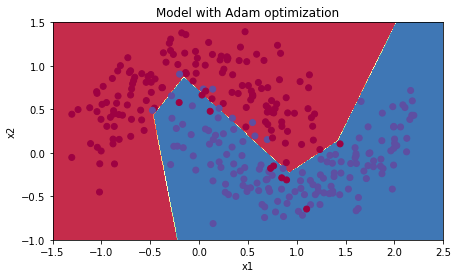

In [34]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)